### Libraries

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from mpl_toolkits.mplot3d import Axes3D

In [3]:
#import wandb

In [4]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import pandas as pd
import random
import sklearn
import time
import math
import matplotlib.pyplot as plt
#import os
import sys

from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm import tqdm
from scipy import stats
#from torchviz import make_dot
from utils import *

In [5]:
os.environ["PATH"] += os.pathsep + '/opt/conda/lib/python3.11/site-packages/graphviz'

### Experiment Setting

In [6]:
robot_choice = "6DoF-6R-Puma260"
seed = True                                                                   # seed random generators for reproducibility
visualize_joints = True                                                       # visualize joint distribution in dataset     
visualize_workspace = True                                                    # visualize workspace (positions)
visualize_losses = True                                                       # visuallze training and validation losses
visualize_normalized_workspace = True                                         # visualize normalized workspace (positions - debugging purposes)
visualize_workspace_results = True                                            # visualize results in workapce
print_inference_summary = True                                                # perform and print inference summary after training is done
print_epoch = True  
batch_size = 128                                                              # desired batch size
init_type = "default"                                                         # weights init method (default, uniform, normal, xavier_uniform, xavier_normal)
hidden_layer_sizes = [128,128,128,128]                                           # architecture to employ
learning_rate = 1e-4                                                          # learning rate
optimizer_choice = "SGD"                                                      # optimizers (SGD, Adam, Adadelta, RMSprop)
loss_choice = "l2"                                                            # l2, l1, lfk
network_type = "MLP"                                                    # MLP, ResMLP, DenseMLP, FouierMLP 

EPOCHS = 10000                                                                # total training epochs


In [7]:
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')         # device to train on
device = torch.device('cuda:0') 
print(device)
print(torch.cuda.is_available())

cuda:0
True


In [8]:
if robot_choice == "6DoF-6R-Puma260":
    n_DoF = 6
    input_dim = 6
    output_dim = 6
    
#data = pd.read_csv('data_'+robot_choice+'_2.csv')
data = pd.read_csv('data_'+robot_choice+'_100000.csv')
data

,x,y,z,R,P,Y,t1,t2,t3,t4,t5,t6
0,-0.261389,0.311482,0.115420,-0.586993,-1.278789,-1.380115,-0.629812,2.914523,-3.645978,-8.694202,0.710476,1.891590
1,0.135785,0.061832,0.076870,0.665025,0.807176,1.979570,-0.661007,3.619466,-1.755622,-3.280697,0.876949,-0.176700
2,-0.157483,-0.191725,-0.087100,0.898328,-0.175826,-1.267496,-3.028592,-0.380646,-2.588374,-4.511964,2.277019,3.368587
3,-0.027957,-0.194814,0.186596,0.423248,-0.616709,1.660441,-2.326550,0.242856,-0.592111,-0.219558,1.070463,4.028561
4,0.181770,-0.048029,-0.406372,2.433396,0.452937,0.431739,-1.018776,1.730768,0.803860,-9.731568,0.219966,-0.428603
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.334948,0.015269,-0.031253,-2.455926,1.278483,-3.107768,-0.461621,-0.856358,-2.821855,-3.959270,0.941655,-2.008148
9996,0.389368,0.056175,-0.110304,0.444737,1.227313,-1.542162,-0.186654,0.985307,0.427624,-6.494938,-0.154600,-0.853975
9997,-0.381207,0.228131,-0.104334,-2.473116,-0.609391,-0.239018,-0.194798,3.327024,0.904829,-7.253536,-0.489336,-3.051767
9998,-0.144977,-0.137629,0.031031,0.153615,0.452777,1.632127,-3.121532,-0.976875,-2.433581,-8.750085,3.378065,2.342534


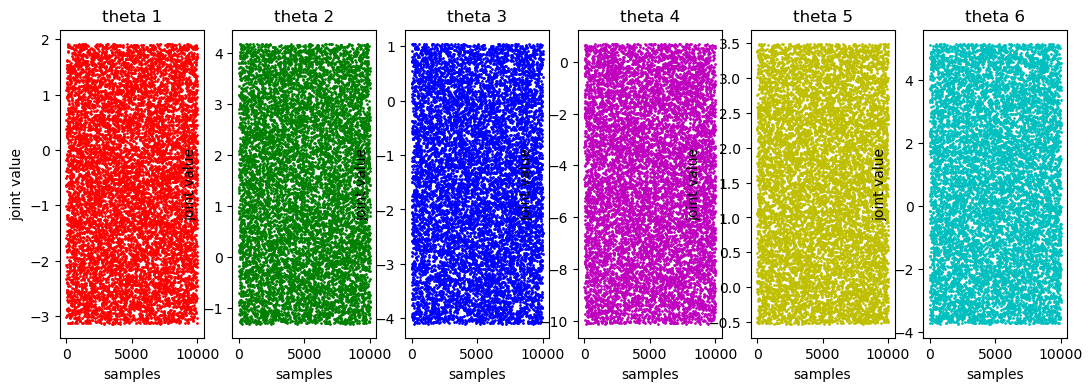

In [9]:
# visualize joints
data_a = np.array(data) 
n_samples = data_a.shape[0]
values = np.linspace(1,n_samples,n_samples)

if visualize_joints:
    """
    fig, axs = plt.subplots(1,4, figsize=(13, 4)) #, sharex=True, sharey=True)
    axs[0].scatter(values, data_a[:,6],s=1, marker='o', c='r')
    axs[0].set(xlabel='samples', ylabel='joint value', title='theta 1')
    axs[1].scatter(values, data_a[:,7],s=1, marker='o', c='g')
    axs[1].set(xlabel='samples', title='theta 2')
    axs[2].scatter(values, data_a[:,8],s=1, marker='o', c='b')
    axs[2].set(xlabel='samples', title='theta 3')
    axs[3].scatter(values, data_a[:,9],s=1, marker='o', c='m')
    axs[3].set(xlabel='samples', title='theta 4')
    """
    colors = ['r', 'g', 'b', 'm', 'y', 'c']

    start_col = input_dim    
    fig, axs = plt.subplots(1,output_dim, figsize=(13, 4)) #, sharex=True, sharey=True)
    for i in range(output_dim):
        axs[i].scatter(values, data_a[:,start_col],s=1, marker='o', c=colors[i])
        axs[i].set(xlabel='samples', ylabel='joint value', title='theta '+str(i+1))
        start_col += 1 

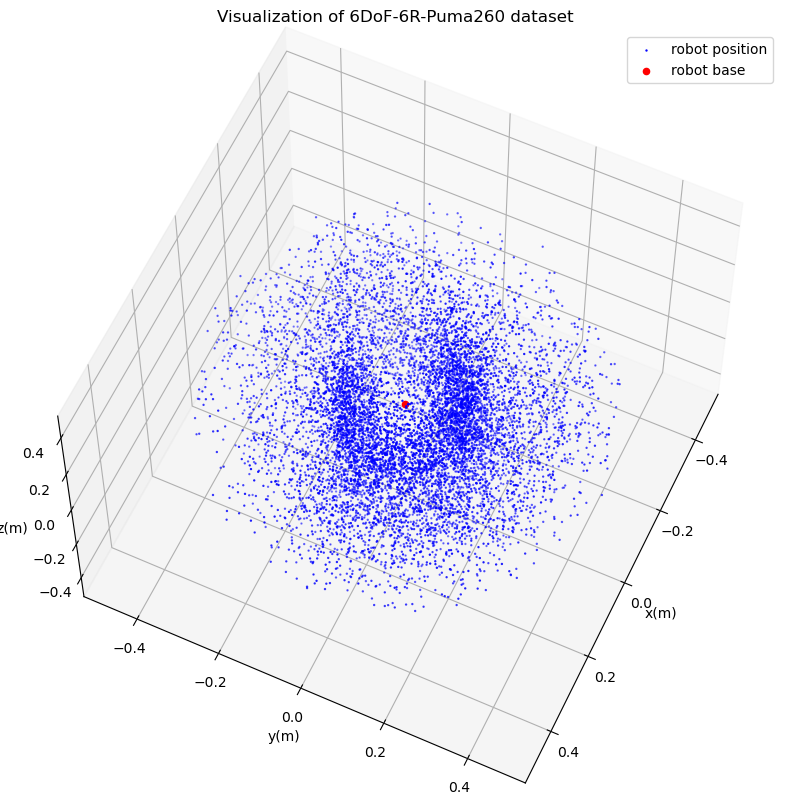

In [10]:
if visualize_workspace:
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.scatter(data_a[:,0], data_a[:,1], data_a[:,2], s=2, c='b', marker='.')
    ax.scatter(0,0,0,s=20, marker='o', c='r')
    ax.legend(["robot position","robot base"])
    ax.set(xlabel='x(m)', ylabel='y(m)', zlabel='z(m)',
           title='Visualization of '+robot_choice+ ' dataset')
    ax.view_init(60, 25)
    plt.show()

### Utilities (Classes and Functions)

In [32]:
## Conversion from PyTorch 3D GitHub repository
def _angle_from_tan(
    axis: str, other_axis: str, data, horizontal: bool, tait_bryan: bool
) -> torch.Tensor:
    """
    Extract the first or third Euler angle from the two members of
    the matrix which are positive constant times its sine and cosine.

    Args:
        axis: Axis label "X" or "Y or "Z" for the angle we are finding.
        other_axis: Axis label "X" or "Y or "Z" for the middle axis in the
            convention.
        data: Rotation matrices as tensor of shape (..., 3, 3).
        horizontal: Whether we are looking for the angle for the third axis,
            which means the relevant entries are in the same row of the
            rotation matrix. If not, they are in the same column.
        tait_bryan: Whether the first and third axes in the convention differ.

    Returns:
        Euler Angles in radians for each matrix in data as a tensor
        of shape (...).
    """

    i1, i2 = {"X": (2, 1), "Y": (0, 2), "Z": (1, 0)}[axis]
    if horizontal:
        i2, i1 = i1, i2
    even = (axis + other_axis) in ["XY", "YZ", "ZX"]
    if horizontal == even:
        return torch.atan2(data[..., i1], data[..., i2])
    if tait_bryan:
        return torch.atan2(-data[..., i2], data[..., i1])
    return torch.atan2(data[..., i2], -data[..., i1])

def _index_from_letter(letter: str) -> int:
    if letter == "X":
        return 0
    if letter == "Y":
        return 1
    if letter == "Z":
        return 2
    raise ValueError("letter must be either X, Y or Z.")

def matrix_to_euler_angles(matrix: torch.Tensor, convention: str) -> torch.Tensor:
    """
    Convert rotations given as rotation matrices to Euler angles in radians.

    Args:
        matrix: Rotation matrices as tensor of shape (..., 3, 3).
        convention: Convention string of three uppercase letters.

    Returns:
        Euler angles in radians as tensor of shape (..., 3).
    """
    if len(convention) != 3:
        raise ValueError("Convention must have 3 letters.")
    if convention[1] in (convention[0], convention[2]):
        raise ValueError(f"Invalid convention {convention}.")
    for letter in convention:
        if letter not in ("X", "Y", "Z"):
            raise ValueError(f"Invalid letter {letter} in convention string.")
    if matrix.size(-1) != 3 or matrix.size(-2) != 3:
        raise ValueError(f"Invalid rotation matrix shape {matrix.shape}.")
    i0 = _index_from_letter(convention[0])
    i2 = _index_from_letter(convention[2])
    tait_bryan = i0 != i2
    if tait_bryan:
        central_angle = torch.asin(
            matrix[..., i0, i2] * (-1.0 if i0 - i2 in [-1, 2] else 1.0)
        )
    else:
        central_angle = torch.acos(matrix[..., i0, i0])

    o = (
        _angle_from_tan(
            convention[0], convention[1], matrix[..., i2], False, tait_bryan
        ),
        central_angle,
        _angle_from_tan(
            convention[2], convention[1], matrix[..., i0, :], True, tait_bryan
        ),
    )
    return torch.stack(o, -1)



# vanilla MLP architecture
class MLP_2(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.name = "MLP[]"
        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):

        # x = [batch size, height, width]
        batch_size = x.shape[0]
        
        x = x.view(batch_size, -1)
        # x = [batch size, height * width]
        
        h_1 = F.relu(self.input_fc(x))
        # h_1 = [batch size, 250]

        h_2 = F.relu(self.hidden_fc(h_1))
        # h_2 = [batch size, 100]

        y_pred = self.output_fc(h_2)
        # y_pred = [batch size, output dim]

        return y_pred, h_2

class MLP(nn.Module):
    def __init__(self, input_dim, h_sizes, output_dim):
        super().__init__()

        self.name = "MLP [{}, {}, {}]".format(str(input_dim), str(h_sizes).replace("[","").replace("]",""), str(output_dim))
        self.input_dim = input_dim
        self.h_sizes = h_sizes
        self.output_dim = output_dim
        
        self.input_fc = nn.Linear(self.input_dim, self.h_sizes[0])
        
        self.hidden_fc = nn.ModuleList()
        for i in range(len(self.h_sizes)-1):
            self.hidden_fc.append(nn.Linear(self.h_sizes[i], self.h_sizes[i+1]))
        
        self.output_fc = nn.Linear(self.h_sizes[len(self.h_sizes)-1], self.output_dim)

        self.selu_activation = nn.SELU()
        self.relu_activation = nn.ReLU()
        self.prelu_activation = nn.PReLU()
        self.lrelu_activation = nn.LeakyReLU()
        self.sigmoid_activation = nn.Sigmoid()
        self.batch_norm_fc = nn.BatchNorm1d(20000)

    def forward(self, x):

        x = self.input_fc(x)
        #x = self.batch_norm_fc(x)
        x = self.relu_activation(x)  # ReLU(), Sigmoid(), LeakyReLU(negative_slope=0.1)

        for i in range(len(self.h_sizes)-1):
            x = self.hidden_fc[i](x)
            #x = self.batch_norm_fc(x)
            x = self.relu_activation(x)

        x = self.output_fc(x)
        x_temp = x

        return x, x_temp 


class ResMLP(nn.Module):
    def __init__(self, input_dim, h_sizes, output_dim):
        super().__init__()

        self.name = "ResMLP [{}, {}, {}]".format(str(input_dim), str(h_sizes).replace("[","").replace("]",""), str(output_dim))
        self.input_dim = input_dim
        self.h_sizes = h_sizes
        self.output_dim = output_dim
        
        self.input_fc = nn.Linear(self.input_dim, self.h_sizes[0])
        self.hidden_fc_1 = nn.Linear(self.h_sizes[0], self.h_sizes[1])
        self.hidden_fc_2 = nn.Linear(self.h_sizes[1], self.h_sizes[2])
        self.hidden_fc_3 = nn.Linear(self.h_sizes[2], self.h_sizes[3])
        self.output_fc = nn.Linear(self.h_sizes[len(self.h_sizes)-1], self.output_dim)       

        self.selu_activation = nn.SELU()
        self.relu_activation = nn.ReLU()
        self.prelu_activation = nn.PReLU()
        self.lrelu_activation = nn.LeakyReLU()
        self.sigmoid_activation = nn.Sigmoid()
        self.batch_norm_fc = nn.BatchNorm1d(20000)

    def forward(self, x):

        x = self.input_fc(x)
        x = self.relu_activation(x)  # ReLU(), Sigmoid(), LeakyReLU(negative_slope=0.1)

        h1 = self.hidden_fc_1(x)
        h1 = self.relu_activation(h1)

        h2 = self.hidden_fc_2(h1)
        h2 = self.relu_activation(h2)

        h3 = self.hidden_fc_3(h2+h1)
        h3 = self.relu_activation(h3)

        o = self.output_fc(h3+h2+h1)
        x_temp = o

        return o, x_temp 


class DenseMLP(nn.Module):
    def __init__(self, input_dim, h_sizes, output_dim):
        super().__init__()

        self.name = "DenseMLP [{}, {}, {}]".format(str(input_dim), str(h_sizes).replace("[","").replace("]",""), str(output_dim))
        self.input_dim = input_dim
        self.h_sizes = h_sizes
        self.output_dim = output_dim
        
        self.input_fc = nn.Linear(self.input_dim, self.h_sizes[0])
        self.hidden_fc_1 = nn.Linear(self.h_sizes[0], self.h_sizes[1])
        self.hidden_fc_2 = nn.Linear(self.h_sizes[1], self.h_sizes[2])
        self.hidden_fc_3 = nn.Linear(self.h_sizes[2]*2, self.h_sizes[3])
        self.output_fc = nn.Linear(self.h_sizes[len(self.h_sizes)-1]*3, self.output_dim)       

        self.selu_activation = nn.SELU()
        self.relu_activation = nn.ReLU()
        self.prelu_activation = nn.PReLU()
        self.lrelu_activation = nn.LeakyReLU()
        self.sigmoid_activation = nn.Sigmoid()
        self.batch_norm_fc = nn.BatchNorm1d(20000)

    def forward(self, x):

        x = self.input_fc(x)
        x = self.relu_activation(x)  # ReLU(), Sigmoid(), LeakyReLU(negative_slope=0.1)

        h1 = self.hidden_fc_1(x)
        h1 = self.relu_activation(h1)

        h2 = self.hidden_fc_2(h1)
        h2 = self.relu_activation(h2)

        #print(h2.shape)
        #sys.exit(0)

        h3 = self.hidden_fc_3(torch.cat((h2,h1),1))
        h3 = self.relu_activation(h3)

        o = self.output_fc(torch.cat((h3,h2,h1),1))
        x_temp = o

        return o, x_temp 


# count network parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# data loader
class LoadIKDataset(Dataset):
    def __init__(self, inputs_array, outputs_array):
        x_temp = inputs_array
        y_temp = outputs_array

        self.x_data = torch.tensor(x_temp, dtype=torch.float32) 
        self.y_data = torch.tensor(y_temp, dtype=torch.float32) 

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        current_input = self.x_data[idx, :]
        current_output = self.y_data[idx, :]
        
        sample = {'input': current_input,
                  'output': current_output}
        return sample
    

    def __len__(self):
        return len(self.x_data)


# function to load the dataset
def load_dataset(data, n_DoF, batch_size):

    # file data_4DoF
    #X = data[:,:3]
    #y = data[:,6:]

    # file data_4DOF_2
    if robot_choice == "6DoF-6R-Puma260":
        X = data[:,:6]
        y = data[:,6:]

        
    #y = data[:,:2]
    #X = data[:,2:]
        
    # split in train and test sets
    X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X, 
                                                                y, 
                                                                test_size = 0.1,
                                                                random_state = 1)

    sc_in = MinMaxScaler(copy=True, feature_range=(0, 1))
    sc_out = MinMaxScaler(copy=True, feature_range=(0, 1))
    
    X_train = sc_in.fit_transform(X_train_i)
    X_test = sc_in.transform(X_test_i)  
    
    #xx = torch.from_numpy(X_train)
    #xx = xx
    #print(xx)
    #print(B.to(torch.float64))
    #X_train = input_mapping(torch.from_numpy(X_train),B.to(torch.float64))
    #X_test = input_mapping(torch.from_numpy(X_test),B.to(torch.float64))
    #X_train = X_train.numpy()
    #X_test = X_test.numpy()
    
    #X_train = X_train_i
    #X_test = X_test_i

    #y_train = sc_out.fit_transform(y_train)
    #y_test = sc_out.transform(y_test) 

    print(X_train.shape)
    print(y_train_i.shape)

    train_data = LoadIKDataset(X_train, y_train_i)
    test_data = LoadIKDataset(X_test, y_test_i)

    train_data_loader = DataLoader(dataset=train_data,
                                   batch_size=batch_size,
                                   shuffle=False,
                                   drop_last=False)

    test_data_loader = DataLoader(dataset=test_data,
                                   batch_size=1,
                                   shuffle=False)

    return train_data_loader, test_data_loader, X_test_i, y_test_i, X_train, y_train_i

# train function
def train(model, iterator, optimizer, criterion, criterion_type, batch_size, device, epoch, EPOCHS):
    epoch_loss = 0
    model.train()
    i = 0

    #B_dict = {}
    #B_dict['basic'] = torch.eye(32,3)
    #B = B_dict['basic'].to(device)
    
    #with tqdm(total=(len(iterator) - len(iterator) % batch_size)) as t:
    with tqdm(total=len(iterator), desc='Epoch: [{}/{}]'.format(epoch+1, EPOCHS), disable=True) as t:
        for data in iterator:
        #for data in tqdm(iterator, desc="Training", leave=False):
            optimizer.zero_grad()
            x, y = data['input'], data['output']
            #print(x)
            #print(y)
            x = x.to(device)
            y = y.to(device)
            
            #x = input_mapping(x,B)
            
            y_pred, _ = model(x)
            #print("\nTrain Epoch {} at batch {}".format(epoch, i))
            """
            if i == 1:
                print("\nTrain Epoch {} at batch {}".format(epoch, i))
                print(y_pred[:5,:])
                print(y[:5,:])
                #sys.exit()
            """
            optimizer.zero_grad()
            #loss = criterion(y_pred, y)
            
            if criterion_type == "lfk":
                loss = criterion(y_pred, x)
            else:
                loss = criterion(y_pred, y)
            #make_dot(loss, params=dict(list(model.named_parameters()))).render("loss", format="png")
            
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            t.set_postfix_str('Train loss: {:.6f}'.format(epoch_loss/len(iterator)))
            t.update()

            i += 1

            #sys.exit()
    
    
    
    #print("Total batches {}".format(i))
        
    return epoch_loss/len(iterator)

# evaluation function 
def evaluate(model, iterator, criterion, criterion_type, device, epoch, EPOCHS):
    epoch_loss = 0
    model.eval()

    #B_dict = {}
    #B_dict['basic'] = torch.eye(32,3)
    #B = B_dict['basic'].to(device)
    
    with torch.no_grad():
        #for data in tqdm(iterator, desc="Evaluating", leave=False):        
        with tqdm(total=len(iterator), desc='Epoch: [{}/{}]'.format(epoch+1, EPOCHS), disable=True) as t:
            for data in iterator:
                x = data['input'].to(device)
                y = data['output'].to(device)

                #x = input_mapping(x,B)
                
                y_pred, _ = model(x)
                #loss = criterion(y_pred, y)
                #loss = criterion(y_pred, x)   
                
                if criterion_type == "lfk":
                    loss = criterion(y_pred, x)
                else:
                    loss = criterion(y_pred, y)
                
                epoch_loss += loss.item()
    
                t.set_postfix_str('Valid loss: {:.6f}'.format(epoch_loss/len(iterator)))
                t.update()

    return epoch_loss/len(iterator)

# make predictions
def inference(model, iterator, criterion, device):
    model.eval()
    y_preds = []
    y_desireds = []
    X_desireds = []
    
    for data in iterator:
        x = data['input'].to(device)
        y = data['output'].to(device)

        #x = input_mapping(x,B)
        
        y_pred, _ = model(x)
        y_preds.append(y_pred.detach().cpu().numpy().squeeze())
        y_desireds.append(y.detach().cpu().numpy().squeeze())
        #X_desireds.append(x.detach().cpu().numpy().squeeze())

    y_desireds = np.array(y_desireds)
    #X_desireds = np.array(X_desireds)
    X_desireds = reconstruct_pose(y_desireds, robot_choice)
    y_preds = np.array(y_preds)
    X_preds = reconstruct_pose(y_preds, robot_choice)

    print(X_preds.shape)
    print(X_desireds.shape)
    
    X_errors = np.abs(X_preds - X_desireds)
    y_errors = np.abs(y_preds - y_desireds)

    print(X_errors.shape)

    X_errors_report = np.array([[X_errors.min(axis=0)],
                                [X_errors.mean(axis=0)],
                                [X_errors.max(axis=0)],
                                [X_errors.std(axis=0)]]).squeeze()
    
    results = {
        "y_preds": y_preds,
        "X_preds": X_preds,
        "y_desireds": y_desireds,
        "X_desireds": X_desireds,
        "X_errors": X_errors_report
    }
    return results

def inference_FK(model, iterator, criterion, device):
    model.eval()
    y_preds = []
    y_desireds = []
    X_desireds = []
    for data in iterator:
        x = data['input'].to(device)
        y = data['output'].to(device)
        y_pred, _ = model(x)
        y_preds.append(y_pred.detach().cpu().numpy().squeeze())
        y_desireds.append(y.detach().cpu().numpy().squeeze())
        X_desireds.append(x.detach().cpu().numpy().squeeze())

    y_desireds = np.array(y_desireds)
    X_desireds = np.array(X_desireds)
    #X_desireds = reconstruct_pose(y_desireds, robot_choice)
    y_preds = np.array(y_preds)
    #X_preds = reconstruct_pose(y_preds, robot_choice)

    #X_errors = np.abs(X_preds - X_desireds)
    y_errors = np.abs(y_preds - y_desireds)

    y_errors_report = np.array([[y_errors.min(axis=0)],
                                [y_errors.mean(axis=0)],
                                [y_errors.max(dim=0)]]).squeeze()
    
    results = {
        "y_preds": y_preds,
        #"X_preds": X_preds,
        "y_desireds": y_desireds,
        #"X_desireds": X_desireds,
        "y_errors": y_errors_report
    }
    return results

# reconstruct positions in cartesian space from predictions
def reconstruct_pose(y_preds, robot_choice):
    y_preds = torch.from_numpy(y_preds)
    n_samples = y_preds.shape[0]
    pose = []
    for i in range(n_samples):
        t = y_preds[i,:]
        DH = get_DH(robot_choice, t)
        T = forward_kinematics(DH)
        if robot_choice == "4DoF-2RPR":
            # x,y,t1,t2,t3 where x,y (m) and t (rad)
            pose.append(T[:3,-1].numpy())
        
        elif robot_choice == "6DoF-6R-Puma260":
            R = T[:3,:3] 
            rpy = matrix_to_euler_angles(R, "XYZ")
            # x,y,z,R,P,Y,t1,t2,t3,t4,t5,t6 where x,y,z (m) and t (rad)
            print(T[:3,-1])
            print(rpy)
            pose.append(torch.cat([T[:3,-1], rpy, t]).numpy())
          
    X_pred = np.array(pose)
    return X_pred
    

# compute epoch time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


# def FFT embedding from this paper: Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains
def input_mapping(x, B):
    if B is None:
        return x
    else:
        x_proj = torch.matmul((2*torch.pi*x), B.T)
        #print(x.shape)
        #print(B.shape)
        #print(x_proj.shape)
        #print(torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1).shape)
    
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
        

class FourierLayer(nn.Module):
    def __init__(self, in_features, out_features, scale):
        super().__init__()
        B = torch.randn(in_features, out_features)*scale
        self.register_buffer("B", B)

    def forward(self, x):
        x_proj = torch.matmul(2*math.pi*x, self.B)
        out = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
        return out

class FourierMLP(nn.Module):
    def __init__(self, input_dim, fourier_dim, h_sizes, output_dim, scale):
        super().__init__()
        
        self.name = "FourierMLP [{}, {}, {}]".format(str(input_dim), str(h_sizes).replace("[","").replace("]",""), str(output_dim))
        self.input_dim = input_dim
        self.fourier_dim = fourier_dim
        self.h_sizes = h_sizes
        self.output_dim = output_dim

        self.fourier_fc = FourierLayer(self.input_dim, self.fourier_dim, scale)
        self.input_fc = nn.Linear(2*self.fourier_dim, self.h_sizes[0])
        
        self.hidden_fc = nn.ModuleList()
        for i in range(len(self.h_sizes)-1):
            self.hidden_fc.append(nn.Linear(self.h_sizes[i], self.h_sizes[i+1]))
        
        self.output_fc = nn.Linear(self.h_sizes[len(self.h_sizes)-1], self.output_dim)

        self.selu_activation = nn.SELU()
        self.relu_activation = nn.ReLU()
        self.prelu_activation = nn.PReLU()
        self.lrelu_activation = nn.LeakyReLU()
        self.sigmoid_activation = nn.Sigmoid()
        self.batch_norm_fc = nn.BatchNorm1d(20000)

    def forward(self, x):

        x = self.fourier_fc(x)
        x = self.input_fc(x)
        x = self.relu_activation(x)  # ReLU(), Sigmoid(), LeakyReLU(negative_slope=0.1)

        for i in range(len(self.h_sizes)-1):
            x = self.hidden_fc[i](x)
            #x = self.batch_norm_fc(x)
            x = self.relu_activation(x)

        x = self.output_fc(x)
        x_temp = x

        return x, x_temp 
        



# compute loss function by employing the FK 
class FKLoss(nn.Module):
    def __init__(self):
        super(FKLoss, self).__init__()
        #self.criterion = nn.MSELoss()
        self.criterion = nn.L1Loss(reduction="mean")

    def forward(self, inputs, targets):
        #inputs_fk = torch.zeros_like(targets)
        inputs_fk = torch.clone(targets)
        print(inputs_fk)
        for i in range(inputs.shape[0]):
            #print()
            DH = get_DH(robot_choice, inputs[i,:])
            #print(DH)
            T = forward_kinematics(DH)
            #print(T.type)
            inputs_fk[i,:] = T[:3,-1]   

        inputs_fk = inputs_fk
        #print(inputs_fk)
        #print(targets)
        loss = self.criterion(inputs_fk, targets)
        #sys.exit()
        return loss




In [30]:
experiments = 1

for experiment_number in range(experiments):

    # ensure reproducibilities if seed is set to true
    if seed:
        SEED = 3    
        random.seed(SEED)
        np.random.seed(SEED)
        torch.manual_seed(SEED)
        torch.cuda.manual_seed(SEED)
        torch.backends.cudnn.deterministic = True
    ## train and validate
    # load the dataset
    train_data_loader, test_data_loader, X_test, y_test, X_train, y_train = load_dataset(data_a, n_DoF, batch_size)
    
    # get network architecture
    if network_type == "MLP":
        model = MLP(input_dim, hidden_layer_sizes, output_dim)
        #model = MLP(mapping_size*2, hidden_layer_sizes, output_dim)
    elif network_type == "ResMLP":
        model = ResMLP(input_dim, hidden_layer_sizes, output_dim)
    elif network_type == "DenseMLP":
        model = DenseMLP(input_dim, hidden_layer_sizes, output_dim)
    elif network_type == "FourierMLP":
        fourier_dim = 16
        scale = 10
        model = FourierMLP(input_dim, fourier_dim, hidden_layer_sizes, output_dim, scale)
        
    
    if init_type == "uniform":
        model.apply(weights_init_uniform_rule)
    elif init_type == "normal":
        model.apply(weights_init_normal_rule)
    elif init_type == "xavier_uniform":
        model.apply(weights_init_xavier_uniform_rule)
    elif init_type == "xavier_normal":
        model.apply(weights_init_xavier_normal_rule)
    elif init_type == "kaiming_uniform":
        model.apply(weights_init_kaiming_uniform_rule)
    elif init_type == "kaiming_normal":
        model.apply(weights_init_kaiming_normal_rule)
        
    model = model.to(device)
    print("==> Architecture: {}\n{}".format(model.name, model))
    print("==> Trainable parameters: {}".format(count_parameters(model)))
    
    # set optimizer
    if optimizer_choice == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
    elif optimizer_choice == "Adam":
        optimizer = optim.Adam(model.parameters())
    elif optimizer_choice == "Adadelta":
        optimizer = optim.Adadelta(model.parameters())
    elif optimizer_choice == "RMSprop":
        optimizer = optim.RMSprop(model.parameters())
    
    # set loss
    if loss_choice == "l2":
        criterion = nn.MSELoss(reduction="mean")
    elif loss_choice == "l1":
        criterion = nn.L1Loss(reduction="mean")
    elif loss_choice == "lfk":
        criterion = FKLoss()
    
    
    print("\n==> Experiment {} Training network: {}".format(experiment_number+1, model.name))
    print("==> Training device: {}".format(device))
    
    
    # create a directory to save weights
    save_path = robot_choice+"_" \
                +model.name.replace(" ","").replace("[","_").replace("]","_").replace(",","-") \
                +optimizer_choice+"_" \
                +loss_choice+"_" \
                +str(experiment_number+1)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    train_losses = []
    valid_losses = []
    best_valid_loss = float('inf')
    start_time_train = time.monotonic()
    start_time = time.monotonic()
    for epoch in range(EPOCHS):
        
        train_loss = train(model, train_data_loader, optimizer, criterion, loss_choice, batch_size, device, epoch, EPOCHS)        
        valid_loss = evaluate(model, test_data_loader, criterion, loss_choice, device, epoch, EPOCHS)
    
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
    
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), save_path+'/best_epoch.pth')
            best_epoch = epoch
        
        
        
        if epoch % (EPOCHS/10) == 0 or epoch == EPOCHS-1:
        #if epoch % (1) == 0 or epoch == EPOCHS-1:
            if print_epoch:
                end_time = time.monotonic()
                epoch_mins, epoch_secs = epoch_time(start_time, end_time)
                print('Epoch: {}/{} | Epoch Time: {}m {}s'.format(epoch, EPOCHS, epoch_mins, epoch_secs))
                print('\tTrain Loss: {}'.format(train_loss))
                print('\tValid Loss: {}'.format(valid_loss))
                print("\tBest Epoch Occurred [{}/{}]".format(best_epoch, EPOCHS))    
            torch.save(model.state_dict(), save_path+'/epoch_'+str(epoch)+'.pth')
    
    end_time_train = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time_train, end_time_train)
    
    if print_epoch:
        print('\nElapsed Time: {}m {}s'.format(epoch_mins, epoch_secs))    

(9000, 6)
(9000, 6)
==> Architecture: MLP [6, 128, 128, 128, 128, 6]
MLP(
  (input_fc): Linear(in_features=6, out_features=128, bias=True)
  (hidden_fc): ModuleList(
    (0-2): 3 x Linear(in_features=128, out_features=128, bias=True)
  )
  (output_fc): Linear(in_features=128, out_features=6, bias=True)
  (selu_activation): SELU()
  (relu_activation): ReLU()
  (prelu_activation): PReLU(num_parameters=1)
  (lrelu_activation): LeakyReLU(negative_slope=0.01)
  (sigmoid_activation): Sigmoid()
  (batch_norm_fc): BatchNorm1d(20000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
==> Trainable parameters: 91207

==> Experiment 1 Training network: MLP [6, 128, 128, 128, 128, 6]
==> Training device: cuda:0
Epoch: 0/10000 | Epoch Time: 0m 0s
	Train Loss: 8.691557521551427
	Valid Loss: 8.529568756341934
	Best Epoch Occurred [0/10000]


KeyboardInterrupt: 

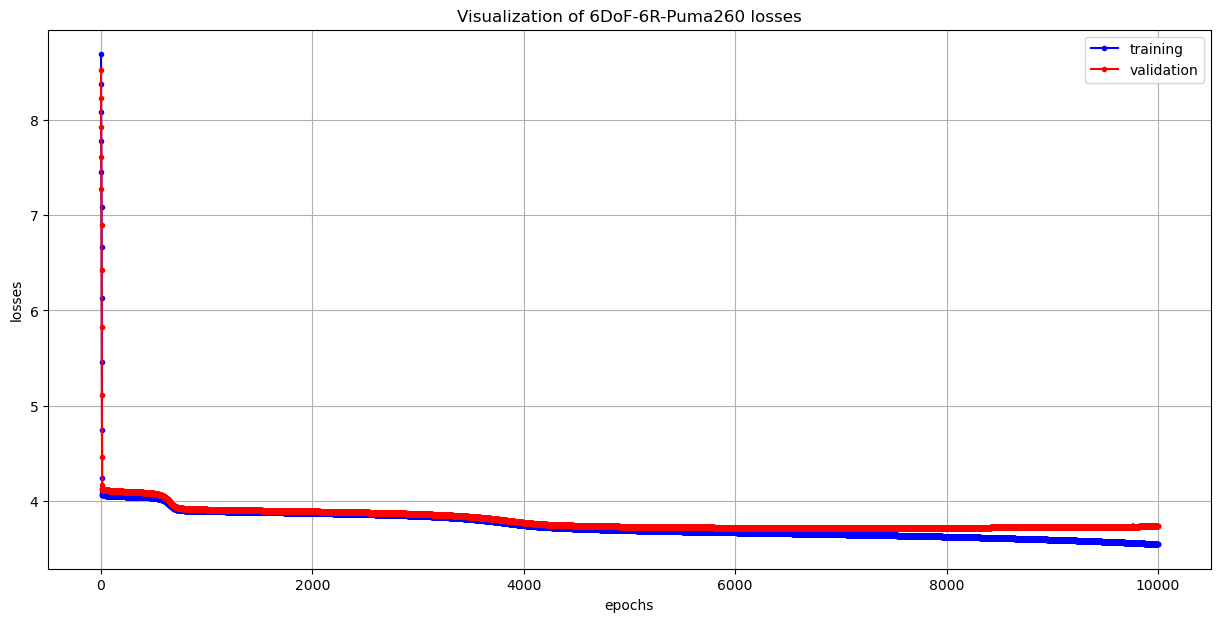

In [13]:
# visualize losses
if visualize_losses:
    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)
    
    fig, ax = plt.subplots(figsize=(15,7))
    ax.plot(train_losses, marker='.', c='b')
    ax.plot(valid_losses, marker='.', c='r')
    ax.set(xlabel='epochs', ylabel='losses',
           title='Visualization of '+robot_choice+ ' losses')
    ax.legend(["training", "validation"])
    ax.grid()

In [20]:
print(save_path)

6DoF-6R-Puma260_MLP_6-128-128-128-128-6_SGD_l2_1


In [31]:
# inference
if print_inference_summary:
    weights_file = save_path+"/best_epoch.pth"
    if network_type == "MLP":
        model = MLP(input_dim, hidden_layer_sizes, output_dim).to(device)
        #model = MLP(mapping_size*2, hidden_layer_sizes, output_dim).to(device)
    elif network_type == "ResMLP":
        model = ResMLP(input_dim, hidden_layer_sizes, output_dim).to(device)
    elif network_type == "DenseMLP":
        model = DenseMLP(input_dim, hidden_layer_sizes, output_dim).to(device)
    
    state_dict = model.state_dict()
    for n, p in torch.load(weights_file, map_location=lambda storage, loc: storage).items():
        if n in state_dict.keys():
            state_dict[n].copy_(p)
        else:
            raise KeyError(n)
    
    # get the results from training
    
    results = inference(model, test_data_loader, criterion, device)
    y_preds = results["y_preds"]
    X_preds = results["X_preds"]
    y_desireds = results["y_desireds"]
    X_desireds = results["X_desireds"]
    X_errors = results["X_errors"]
    
    print("==> y_preds {}: min = {:.4f} / mean = {:.4f} / max = {:.4f}\n{}\n".format(y_preds.shape, y_preds.min(), y_preds.mean(), y_preds.max(), y_preds))
    print("==> y_test {}: min = {:.4f} / mean = {:.4f} / max = {:.4f}\n{}\n".format(y_test.shape, y_test.min(), y_test.mean(), y_test.max(), y_test))
    
    print("==> X_preds {}: min = {:.4f} / mean = {:.4f} / max = {:.4f}\n{}\n".format(X_preds.shape, X_preds.min(), X_preds.mean(), X_preds.max(), X_preds))
    print("==> X_test {}: min = {:.4f} / mean = {:.4f} / max = {:.4f}\n{}\n".format(X_test.shape, X_test.min(), X_test.mean(), X_test.max(), X_test))
    
    
    with np.printoptions(precision=4, suppress=True):
        #X_errors[:3,:] = 
        print(X_errors.T*1000)
    #print("X_errors (mm): \n{}".format(X_errors*1000))

    #results = inference_FK(model, test_data_loader, criterion, device)
    #y_preds = results["y_preds"]
    #y_desireds = results["y_desireds"]
    #y_errors = results["y_errors"]
    
    #print("==> y_preds {}: min = {:.4f} / mean = {:.4f} / max = {:.4f}\n{}\n".format(y_preds.shape, y_preds.min(), y_preds.mean(), y_preds.max(), y_preds))
    #print("==> y_test {}: min = {:.4f} / mean = {:.4f} / max = {:.4f}\n{}\n".format(y_test.shape, y_test.min(), y_test.mean(), y_test.max(), y_test))
    #print("y_errors (mm): \n{}".format(y_errors*1000))
    
    
    X_errors_p = np.abs(X_preds - X_desireds)*1000

(1000, 12)
(1000, 12)
(1000, 12)
==> y_preds (1000, 6): min = -5.3751 / mean = -0.5330 / max = 1.6875
[[-0.6540526   1.4426397  -1.5225271  -4.6371994   1.4406366   0.7159183 ]
 [-0.6321301   1.4029846  -1.4774486  -4.5242467   1.4064825   0.6952011 ]
 [-0.6116302   1.3549567  -1.4346498  -4.3744526   1.3630872   0.67104393]
 ...
 [-0.5805111   1.2922379  -1.3677227  -4.1871843   1.3040223   0.63708436]
 [-0.58754283  1.304825   -1.3812883  -4.2283125   1.3173547   0.6434542 ]
 [-0.69980174  1.5397288  -1.6271178  -4.929285    1.5326147   0.7668038 ]]

==> y_test (1000, 6): min = -10.1141 / mean = -0.5333 / max = 5.1289
[[-0.5158758   1.0929427  -3.606612   -4.439578    2.0896487   0.55253196]
 [ 0.6140554   1.2649093  -0.28495884 -2.633347    3.18758     4.6197996 ]
 [ 1.0260069   1.0017455  -2.584568   -7.8879867   3.414885    2.6628006 ]
 ...
 [-1.0371504   1.1033432  -2.9248776  -4.2201815  -0.46272653  3.4551928 ]
 [ 0.45009232  2.6587977  -0.297611    0.23069668  2.920792   -2.54

In [18]:
if print_inference_summary:
    # percentage of errors less than 1mm, 5mm, 10mm (1cm), 15mm (1.5cm), 20mm (2cm)
    X_percentile = stats.percentileofscore(X_errors_p[:,0], [1,5,10,15,20], kind='rank')
    Y_percentile = stats.percentileofscore(X_errors_p[:,1], [1,5,10,15,20], kind='rank')
    Z_percentile = stats.percentileofscore(X_errors_p[:,2], [1,5,10,15,20], kind='rank')
    print("X_percentile: {}".format(X_percentile))
    print("Y_percentile: {}".format(Y_percentile))
    print("Z_percentile: {}".format(Z_percentile))

X_percentile: [0.25 1.75 4.05 6.05 8.3 ]
Y_percentile: [0.35 1.95 4.15 6.35 8.4 ]
Z_percentile: [ 0.85  4.    7.4  11.6  15.15]


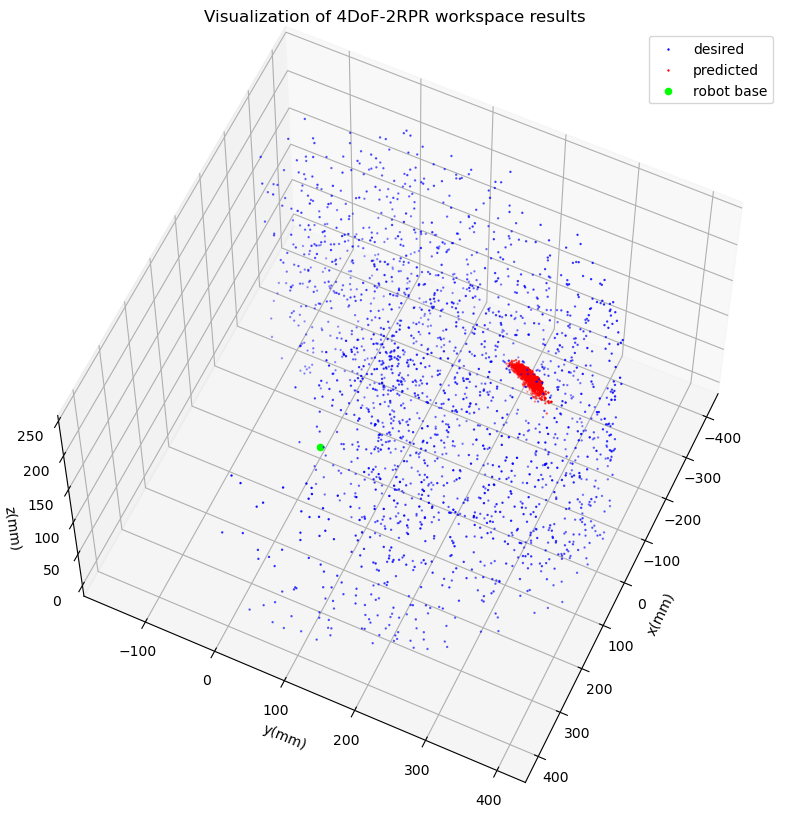

In [19]:
if visualize_workspace_results:
    X_desireds = X_desireds*1000
    X_preds = X_preds*1000    
    
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.scatter(X_desireds[:,0], X_desireds[:,1], X_desireds[:,2], s=2, c='b', marker='.')
    ax.scatter(X_preds[:,0], X_preds[:,1], X_preds[:,2], s=2, c='r', marker='.')
    ax.scatter(0,0,0,s=20, marker='o', c='lime')
    ax.legend(["desired", "predicted", "robot base"])
    ax.set(xlabel='x(mm)', ylabel='y(mm)', zlabel='z(mm)',
           title='Visualization of '+robot_choice+ ' workspace results')
    ax.view_init(60, 25)
    plt.show()

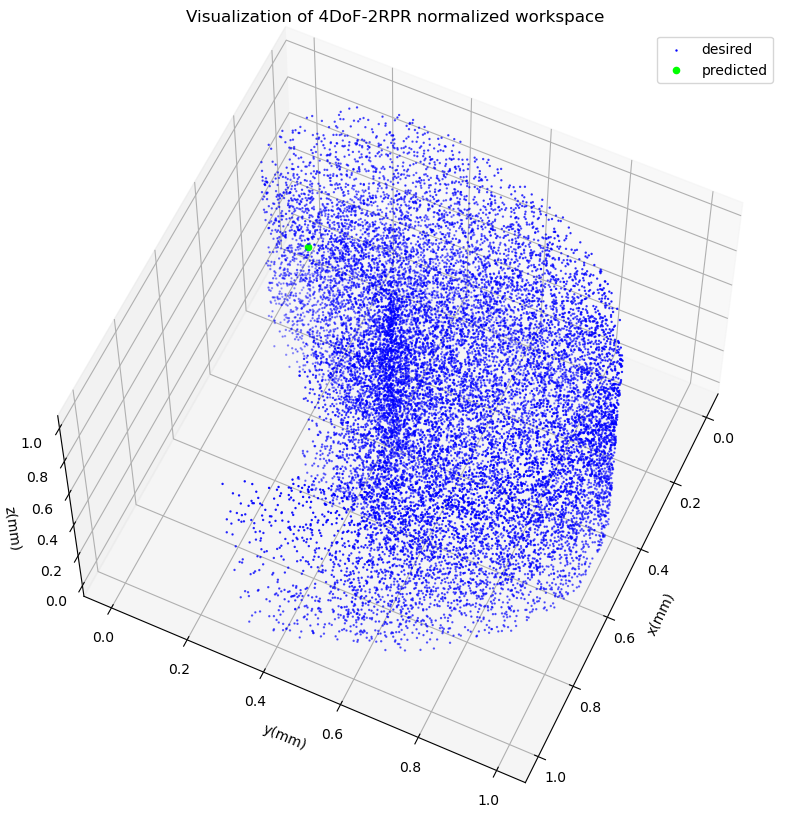

In [20]:
if visualize_normalized_workspace:
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.scatter(X_train[:,0], X_train[:,1], X_train[:,2], s=2, c='b', marker='.')
    ax.scatter(0,0,0,s=20, marker='o', c='lime')
    ax.legend(["desired", "predicted", "robot base"])
    ax.set(xlabel='x(mm)', ylabel='y(mm)', zlabel='z(mm)',
           title='Visualization of '+robot_choice+ ' normalized workspace')
    ax.view_init(60, 25)
    plt.show()